In [1]:
import pandas as pd
import numpy as np
import liwc
import re
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data and dictionaries
df = pd.read_csv ('IchBinHanna.csv')
german_parse, german_categories = liwc.load_token_parser('LIWC2007_German.dic')
english_parse, english_categories = liwc.load_token_parser('LIWC2015_English.dic')

In [3]:
#prepare data, drop retweets and split it into german and english tweets
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df['text'] = df['text'].replace(r'\\n',  ' ', regex=True)
df['text'] = df['text'].apply(rem_url)
df['text'] = df['text'].astype(str)
#tokenize tweets
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['text'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]

In [4]:
df_ger['categories'] = df_ger['tokenized'].apply(lambda x: Counter(category for token in x for category in german_parse(token)))
df_en['categories'] = df_en['tokenized'].apply(lambda x: Counter(category for token in x for category in english_parse(token)))

In [5]:
#function to get relative scores of each category
def get_relative(cats, tokens):
    out = {}
    for k in cats:
        out[k] = round(cats[k]/len(tokens),4)
    return out

In [6]:
#convert counter to dict
df_en['categories'] = df_en['categories'].apply(lambda x: dict(x))
df_ger['categories'] = df_ger['categories'].apply(lambda x: dict(x))
#get percentage of classes
df_en['categories'] = [get_relative(x, y) for x, y in zip(df_en['categories'], df_en['tokenized'])]
df_ger['categories'] = [get_relative(x, y) for x, y in zip(df_ger['categories'], df_ger['tokenized'])]

In [7]:
#only keep sentiment information from category-list and align category names from the different dictionarys (Posfeel from the german dictionary is excluded, as all words from this category are also Posemo)
cat_list = ['Posemo', 'Negemo', 'Anx', 'Sad', 'Anger',  'posemo (Positive Emotions)', 'negemo (Negative Emotions)', 'anx (Anx)', 'sad (Sad)', 'anger (Anger)']
def keep_cats(cats):
    out={}
    for k in cats:
        if k in cat_list:
            if k == 'posemo (Positive Emotions)':
                out['Posemo'] = cats[k]
            elif k == 'negemo (Negative Emotions)':
                out['Negemo'] = cats[k]
            elif k == 'anx (Anx)':
                out['Anx'] = cats[k]
            elif k == 'sad (Sad)':
                out['Sad'] = cats[k]
            elif k == 'anger (Anger)':
                out['Anger'] = cats[k]
            else:
                out[k] = cats[k]
    return out

In [8]:
df_en['categories'] = [keep_cats(x) for x in df_en['categories']]
df_ger['categories'] = [keep_cats(x) for x in df_ger['categories']]

In [9]:
#create new columns for each score
df_en[['Posemo', 'Negemo','Anx','Anger', 'Sad']] = df_en['categories'].apply(pd.Series)

In [10]:
#make index for the new columns coherent
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df
df_en = df_column_switch(df_en, 'Sad', 'Anger')

In [11]:
#rejoin data frame, then fill sentiment values with NaN with zeros
df_sentiment = pd.concat([df_en,df_ger])
df_sentiment['Posemo'] = df_sentiment['Posemo'].fillna(0.0)
df_sentiment['Negemo'] = df_sentiment['Negemo'].fillna(0.0)
df_sentiment['Anger'] = df_sentiment['Anger'].fillna(0.0)
df_sentiment['Sad'] = df_sentiment['Sad'].fillna(0.0)
df_sentiment['Anx'] = df_sentiment['Anx'].fillna(0.0)

In [19]:
df_sentiment['Sentiment Score'] = df_sentiment['Posemo'] - df_sentiment['Negemo']

In [20]:
#some descriptive statistics
print("Max and Min Sentiment scores:\n Max:{0}\n Min:{1}".format(df_sentiment['Sentiment Score'].max(), df_sentiment['Sentiment Score'].min()))
print("Mean Sentiment score:\n {0}".format(round(df_sentiment['Sentiment Score'].mean(),4)))

Max and Min Sentiment scores:
 Max:0.5
 Min:-1.0
Mean Sentiment score:
 0.0023


In [22]:
conditions = [(df_sentiment['Sentiment Score'] < 0), (df_sentiment['Sentiment Score'] == 0),(df_sentiment['Sentiment Score'] > 0)]
values = ['negative', 'neutral', 'positive']
df_sentiment['sentiment'] = np.select(conditions, values)
df_sentiment['sentiment'].value_counts()

neutral     22509
positive     1387
negative      607
Name: sentiment, dtype: int64

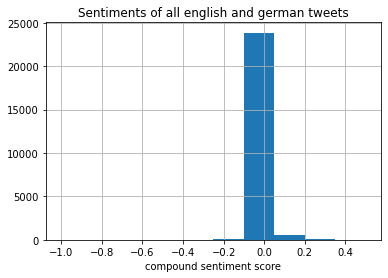

In [23]:
#distribution of overall sentiment scores
df_sentiment['Sentiment Score'].hist()
plt.title('Sentiments of all english and german tweets')
plt.xlabel('compound sentiment score')
plt.show()

In [24]:
df_day = df_sentiment[['new_date', 'Sentiment Score']]
#compute mean scores over days
df_day = df_day.groupby([pd.to_datetime(df_day['new_date']).dt.date]).mean()
df_day = df_day.reset_index()

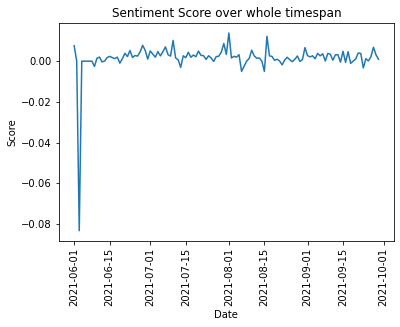

In [25]:
plt.plot(df_day['new_date'],df_day['Sentiment Score'])
plt.title('Sentiment Score over whole timespan')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

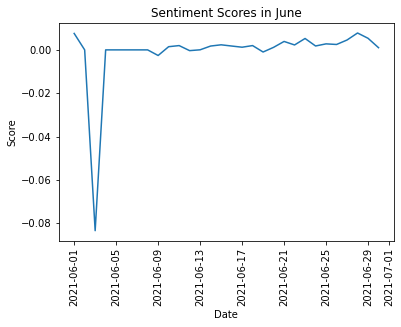

In [29]:
#for a better overview, split the data into months
df_june = df_day.loc[df_day['new_date'] < pd.to_datetime('2021-07-01')]
plt.plot(df_june['new_date'],df_june['Sentiment Score'])
plt.title('Sentiment Scores in June')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

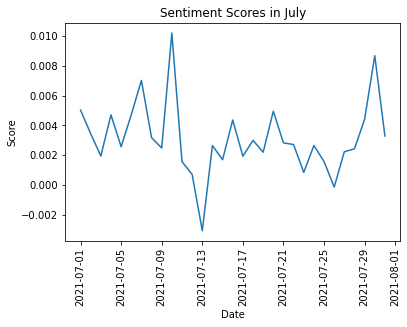

In [30]:
df_july = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_day['new_date'] < pd.to_datetime('2021-08-01'))]
plt.plot(df_july['new_date'],df_july['Sentiment Score'])
plt.title('Sentiment Scores in July')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

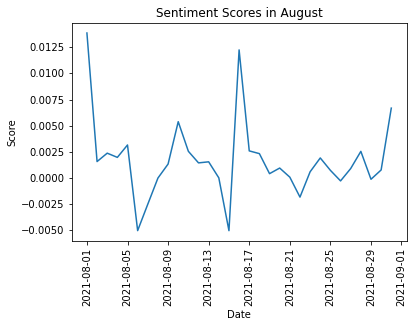

In [31]:
df_august = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_day['new_date'] < pd.to_datetime('2021-09-01'))]
plt.plot(df_august['new_date'],df_august['Sentiment Score'])
plt.title('Sentiment Scores in August')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

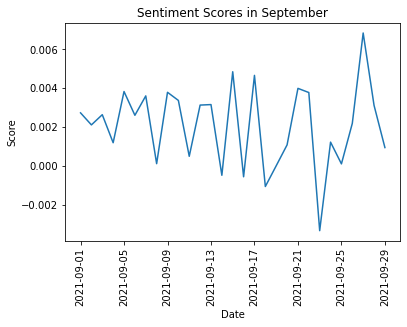

In [33]:
df_september = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_day['new_date'] < pd.to_datetime('2021-10-01'))]
plt.plot(df_september['new_date'],df_september['Sentiment Score'])
plt.title('Sentiment Scores in September')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()